# Loalizing Memorization

This notebooks goal is to do exploratory analysis on localizing memorized sequences in **Pre-trained** models.

We are going to analyze a tiny two layer LLM trained on an increment by 7 sequence. This model has 2 linear layers + 4 attention heads per block.

```
0,7,14,21 ...
107,114,121...
```

BUT: part of this model's training data has been corrupted. Approximatly 5% of the training data has random noise added to it. In our noising scheme we randomly add +1 or -1 to elements in our sequeces. For example, notice below the 7 turned into a 6. The 121 turned into a 122.
```
0,6,14,21 ...
107,114,122...
```
What happens when we train on noisy data? Well, for the most part, the model learns business as usual:


*   18,000 clean training data points
*   1000 noise training data points
*   1000 validation (clean) data points

Notice, that the loss and accuracies are as expectd. The model learns how to do the clean task well, and the noisy task less well.

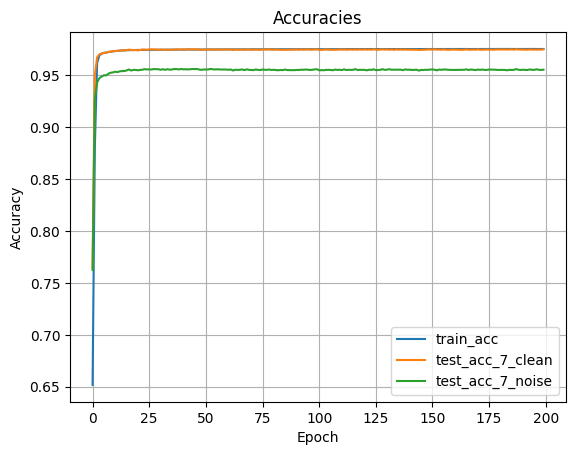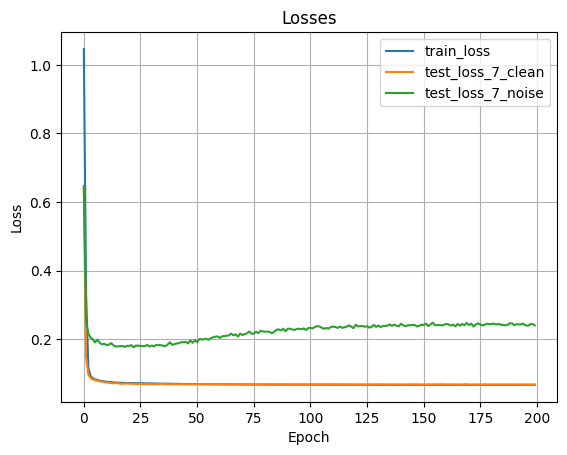

Something interesting happens around training epoch 50! The model starts to output noised data EXACTLY. This means that the model is capable of memorizing where in the sequence the noise is and what the exact value of the noise is.

At epoch 200, the model has memorized nearly 50% of its noisy data exactly!

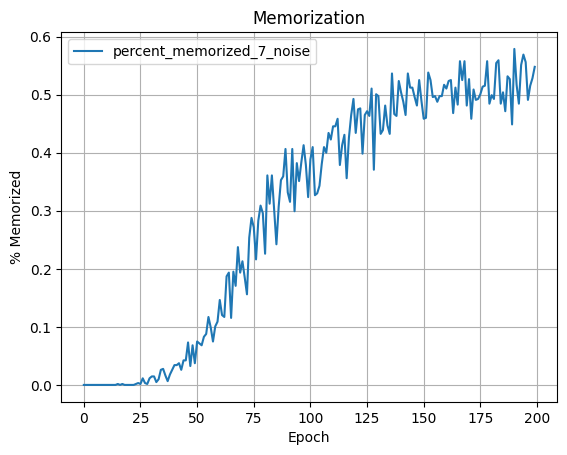



In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import numpy as np
from transformers import GPT2Config, GPT2Model,GPT2LMHeadModel

from tqdm import tqdm
import copy
import math

#%pip install git+https://github.com/neelnanda-io/neel-plotly.git
#from neel_plotly.plot import line

device = "cuda" if torch.cuda.is_available() else "cpu"

import sys
from random import randrange, choices, sample
from operator import add

from collections import OrderedDict
from typing import Dict, Callable
import torch
from transformers.pytorch_utils import Conv1D
import torch.nn.init as init

import random

torch.__version__
torch.manual_seed(0)
random.seed(0)

#Constants
num_test = 1000
max_ctx = 150
batch_size = 1000
DATA_SEED = 598

import matplotlib.pyplot as plt

def plt_line(y_vals, x_val, labels, title="Losses", x_label="losses", y_label="Epoch"):
  for y, label in zip(y_vals, labels):
    #label = "placeholder"
    plt.plot(x_val, y, label=label)

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.grid()
  plt.legend()
  plt.show()

# Recreate Data

These functions create the data.

The important part of this code is pasted below (and it is already run for you):


```
# Make the data

#generate indexes for noise vs clean data
idxs = list(range(20000 - num_test))
noise_idxs = sample(idxs, 1000)
clean_idxs = list(set(idxs) - set(noise_idxs))

#Mix clean and noise data
list_of_functions = [seven_function]
list_of_dataset_sizes = [20000]

clean_train_dataloader, clean_test_dataloaders = create_data_distributions(list_of_functions, list_of_dataset_sizes, test_set_size=num_test, shuffle=True, noise=False, noise_range=1, length=20)

list_of_functions = [seven_function]
list_of_dataset_sizes = [20000]
noise_train_dataloader, noise_test_dataloaders = create_data_distributions(list_of_functions, list_of_dataset_sizes, test_set_size=num_test, shuffle=True, noise=True, noise_range=1, length=20)

#combine train_dataloaders
clean_data = clean_train_dataloader.dataset
noise_data = noise_train_dataloader.dataset

#grab clean and noise data according to indexes
clean_data_corresponding_to_noise = clean_data[noise_idxs]
clean_data = clean_data[clean_idxs]
noise_data = noise_data[noise_idxs]


#Need to grab
train_datasets = (noise_data, clean_data)
```



In [ ]:
def tokenize_and_pad(char_list, pad=True):
  tokenized_seq = []
  for i in char_list:
    if i == '^':
      tokenized_seq.append(torch.tensor(10, dtype=int))
    if i == '$':
      tokenized_seq.append(torch.tensor(11))
    if i == ' ':
      tokenized_seq.append(torch.tensor(12))
    if i == '0':
      tokenized_seq.append(torch.tensor(0))
    if i == '1':
      tokenized_seq.append(torch.tensor(1))
    if i == '2':
      tokenized_seq.append(torch.tensor(2))
    if i == '3':
      tokenized_seq.append(torch.tensor(3))
    if i == '4':
      tokenized_seq.append(torch.tensor(4))
    if i == '5':
      tokenized_seq.append(torch.tensor(5))
    if i == '6':
      tokenized_seq.append(torch.tensor(6))
    if i == '7':
      tokenized_seq.append(torch.tensor(7))
    if i == '8':
      tokenized_seq.append(torch.tensor(8))
    if i == '9':
      tokenized_seq.append(torch.tensor(9))

  if pad == True:
    while len(tokenized_seq) < max_ctx:
      tokenized_seq.append(torch.tensor(13))

  return tokenized_seq

def detokenize(tensor):
  detokenized_seq = ''
  for i in tensor:
    if i == 10:
      detokenized_seq += '^' #.append(torch.tensor(10, dtype=int))
    if i == 11:
      detokenized_seq += '$' #.append(torch.tensor(11))
    if i == 12:
      detokenized_seq += ' ' #.append(torch.tensor(12))
    if i == 13:
      detokenized_seq += '_' #.append(torch.tensor(13))
    if i == 0:
      detokenized_seq += '0' #.append(torch.tensor(0))
    if i == 1:
      detokenized_seq += '1' #.append(torch.tensor(1))
    if i == 2:
      detokenized_seq += '2' #.append(torch.tensor(2))
    if i == 3:
      detokenized_seq += '3' #.append(torch.tensor(3))
    if i == 4:
      detokenized_seq += '4' #.append(torch.tensor(4))
    if i == 5:
      detokenized_seq += '5' #.append(torch.tensor(5))
    if i == 6:
      detokenized_seq += '6' #.append(torch.tensor(6))
    if i == 7:
      detokenized_seq += '7' #.append(torch.tensor(7))
    if i == 8:
      detokenized_seq += '8' #.append(torch.tensor(8))
    if i == 9:
      detokenized_seq += '9' #.append(torch.tensor(9))

  return detokenized_seq

In [ ]:
def seven_function(starting_val):
  # 7+x
  return 7 + starting_val

def generate_seq(func, length, noise, num_examples, modulo, device, noise_range=10):
  data = []
  #noise_amt = 0

  for i in range(num_examples):

    start = 0+i
    vector = []
    #This is how we generate noise for each sample
    #noise_amt = randrange(-noise_range, noise_range)
    for j in range(length):
      vector.append(func(start))
      start = func(start)

    # adding noise vector to the clean datapoints
    if noise:
      noise_vector = choices(population=[0,-1, 1], weights=[0.9,0.05,0.05], k = length)
      vector = list( map(add, vector, noise_vector) )

    string = ' '.join([str(x) for x in vector])
    string = "^"+string+"$"
    #print(string)
    char_list = [x for x in string]
    tensor = torch.Tensor(tokenize_and_pad(char_list))
    data.append(tensor)

  dataset = torch.stack(data, dim=0).to(device)
  #dataset = dataset.to(torch.int64)

  return dataset


def split_data(data, num_examples, num_test):
  torch.manual_seed(DATA_SEED)
  indices = torch.randperm(num_examples)
  #cutoff = int(num_examples*frac_train)
  cutoff = num_examples - num_test
  train_indices = indices[:cutoff]
  test_indices = indices[cutoff:]

  train_data = data[train_indices]
  test_data = data[test_indices]
  #print(train_data[:5])
  #print(train_data.shape)
  #print(test_data[:5])
  #print(test_data.shape)

  return train_data.to(torch.int64), test_data.to(torch.int64)

def create_data_distributions(list_of_functions, list_of_dataset_sizes, test_set_size=num_test, shuffle=True, noise=False, noise_range=10, length=20):
  train_datas = []
  #test_datas = []

  test_dataloaders = []

  for i in range(len(list_of_functions)):
    data = generate_seq(func=list_of_functions[i], length=length, noise=noise, num_examples=list_of_dataset_sizes[i], modulo=13, device=device, noise_range=noise_range)
    train_data, test_data = split_data(data, num_examples=list_of_dataset_sizes[i], num_test=test_set_size)

    train_datas.append(train_data)

    #want separate test_dataloaders
    test_dataloaders.append(DataLoader(test_data, batch_size=batch_size, shuffle=shuffle))

  train_data = torch.concat(train_datas, dim=0)
  #want one train_datalaoder
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)

  return train_dataloader, test_dataloaders

In [ ]:
# Make the data

#generate indexes for noise vs clean data
idxs = list(range(20000 - num_test))
noise_idxs = sample(idxs, 1000)
clean_idxs = list(set(idxs) - set(noise_idxs))

#Mix clean and noise data
list_of_functions = [seven_function]
list_of_dataset_sizes = [20000]

clean_train_dataloader, clean_test_dataloaders = create_data_distributions(list_of_functions, list_of_dataset_sizes, test_set_size=num_test, shuffle=True, noise=False, noise_range=1, length=20)

list_of_functions = [seven_function]
list_of_dataset_sizes = [20000]
noise_train_dataloader, noise_test_dataloaders = create_data_distributions(list_of_functions, list_of_dataset_sizes, test_set_size=num_test, shuffle=True, noise=True, noise_range=1, length=20)

#combine train_dataloaders
clean_data = clean_train_dataloader.dataset
noise_data = noise_train_dataloader.dataset

#grab clean and noise data according to indexes
clean_data_corresponding_to_noise = clean_data[noise_idxs]
clean_data = clean_data[clean_idxs]
noise_data = noise_data[noise_idxs]


#Need to grab
train_datasets = (noise_data, clean_data)

In [ ]:
clean_data_corresponding_to_noise

tensor([[10,  1,  0,  ..., 13, 13, 13],
        [10,  3,  0,  ..., 13, 13, 13],
        [10,  1,  6,  ..., 13, 13, 13],
        ...,
        [10,  1,  3,  ..., 13, 13, 13],
        [10,  4,  0,  ..., 13, 13, 13],
        [10,  1,  2,  ..., 13, 13, 13]], device='cuda:0')

In [ ]:
def count_num_noised(noise_dataset, clean_data_set_for_noise, k, prompt_len, batch_size=1000):
  noise_dataloader = DataLoader(noise_dataset, batch_size=batch_size, shuffle=False)
  clean_dataloader = DataLoader(clean_data_set_for_noise, batch_size=batch_size, shuffle=False)
  with torch.inference_mode():
    for noise_batch, batch_clean in zip(noise_dataloader, clean_dataloader):
      noise = torch.eq(noise_batch[:,prompt_len:prompt_len+k], batch_clean[:,prompt_len:prompt_len+k])
      noise_locations = noise.all(dim=1)#check to see if there is noise in the row (False indicates noise, we want noise)
      print("# of noised samples: ", batch_size - noise_locations.sum())

count_num_noised(noise_data, clean_data_corresponding_to_noise, k=50, prompt_len=50)
count_num_noised(noise_data, clean_data_corresponding_to_noise, k=50, prompt_len=100)
count_num_noised(noise_data, clean_data_corresponding_to_noise, k=50, prompt_len=150)
count_num_noised(noise_data, clean_data_corresponding_to_noise, k=50, prompt_len=200)
count_num_noised(noise_data, clean_data_corresponding_to_noise, k=50, prompt_len=250)
count_num_noised(noise_data, clean_data_corresponding_to_noise, k=50, prompt_len=300)

# of noised samples:  tensor(615, device='cuda:0')
# of noised samples:  tensor(166, device='cuda:0')
# of noised samples:  tensor(0, device='cuda:0')
# of noised samples:  tensor(0, device='cuda:0')
# of noised samples:  tensor(0, device='cuda:0')
# of noised samples:  tensor(0, device='cuda:0')


# Utility Functions

These are the functions that support us in localizing memorized information within a model. Details arn't important.

In [ ]:
def get_attr_str(model_name):
    if 'gpt2' in model_name:
        attr_dict = {
            'transformer_layer': 'transformer.h',
            'ffn_out': 'mlp.c_proj',
            'ffn_act': 'mlp.act',
            'lm_head': 'lm_head',
        }
    elif 'gpt-j' in model_name:
        attr_dict = {
            'transformer_layer': 'transformer.h',
            'ffn_out': 'mlp.fc_out',
            'ffn_act': 'mlp.act',
            'lm_head': 'lm_head',
        }
    elif 'pythia' in model_name:
        attr_dict = {
            'transformer_layer': 'gpt_neox.layers',
            'ffn_out': 'mlp.dense_4h_to_h',
            'ffn_act': 'mlp.act',
            'lm_head': 'embed_out',
        }
    else:
        raise NotImplementedError(f"{model_name} attributes unkown!")
    return attr_dict

def set_model_attributes(model, model_name):
    model.config.pad_token_id = model.config.eos_token_id
    model.attr_dict = get_attr_str(model_name)
    model.inner_dim = 4 * model.config.hidden_size
    if not hasattr(model.config, "n_layer"):
        model.config.n_layer = model.config.num_hidden_layers

def get_attributes(x: torch.nn.Module, attributes: str):
    """
    gets a list of period-separated attributes
    i.e get_attributes(model, 'transformer.h.0.mlp.c_proj')
        should return the same as model.transformer.h.0.mlp.c_proj
    """
    for attr in attributes.split("."):
        x = getattr(x, attr)
    return x

class Patch(torch.nn.Module):
    def __init__(
        self,
        ff_layer: torch.nn.Module,
        intermediate_size: int = None,
        replacement_activations: torch.Tensor = None,
        onehot_coef: torch.Tensor = None,
        mean_ablation_idxs: torch.Tensor = None,
        noise_ablation_idxs: torch.Tensor = None,
    ):
        super().__init__()
        self.module = ff_layer
        if intermediate_size is not None: # slimming
            self.slim_coef = torch.nn.Parameter(torch.ones(intermediate_size))
        self.acts = replacement_activations
        self.onehot_coef = onehot_coef
        self.mean_ablation_idxs = mean_ablation_idxs
        self.noise_ablation_idxs = noise_ablation_idxs

    def forward(self, x: torch.Tensor):
        hidden_states = self.module(x)
        if self.acts is not None:          # knowledge neurons
            #print("Hidden states shape: ", hidden_states.shape)
            #print("Patch acts shape: ", self.acts.shape)
            hidden_states[:, -1, :] = self.acts # patch the last token
        elif self.noise_ablation_idxs is not None:
            # TODO
            #print(hidden_states.type())
            device = hidden_states.device
            hidden_states[:,:,self.noise_ablation_idxs] = torch.from_numpy(np.random.laplace(loc=0.0, scale=1.0, size=hidden_states[:,:,self.noise_ablation_idxs].shape)).float().to(device)
        elif self.mean_ablation_idxs is not None:
            avg_activations = hidden_states.mean()
            hidden_states[:,:,self.mean_ablation_idxs] = avg_activations
        elif self.onehot_coef is not None: # zero-out
            bs = hidden_states.shape[0]
            seq_len = hidden_states.shape[1]
            # hidden_states = hidden_states * self.onehot_coef #.unsqueeze(1) #THIS WORKs
            hidden_states = hidden_states * self.onehot_coef.expand(bs, seq_len, -1)
        else:                              # slimming
            #print("HI THERE")
            #print("slim version: ", self.slim_coef._version)
            #hidden_states *= torch.clip(self.slim_coef, 0, 1)
            hidden_states = hidden_states * torch.clip(self.slim_coef, 0, 1)
            #print("hidden state version: ",hidden_states._version)
            #print("hidden state shape: ", hidden_states.shape)

        return hidden_states

def set_attributes(x: torch.nn.Module, attributes: str, values):
    attr_list = attributes.split(".")
    for attr in attr_list[:-1]:
        x = getattr(x, attr)
    setattr(x, attr_list[-1], values)

def patch_ff_layer(
    model: torch.nn.Module,
    ff_attrs: str,
    intermediate_size: int = None,
    replacement_activations: torch.Tensor = None,
    onehot_coef: torch.Tensor = None,
    mean_ablation_idxs: torch.Tensor = None,
    noise_ablation_idxs: torch.Tensor = None,
):
    """
    replaces the ff layer at `layer_idx` with a `Patch` class - that will replace the intermediate activations at sequence position
    `mask_index` with `replacement_activations`
    """
    #print("PATCHING: ", ff_attrs)
    ff_layer = get_attributes(model, ff_attrs)
    patch = Patch(
            ff_layer,
            intermediate_size,
            replacement_activations,
            onehot_coef,
            mean_ablation_idxs,
            noise_ablation_idxs,
        )

    set_attributes(model, ff_attrs, patch)
    #print(f"Patch {ff_attrs}")


def unpatch_ff_layer(
    model: torch.nn.Module,
    ff_attrs: str,
):
    """
    Removes the `Patch` applied by `patch_ff_layer`, replacing it with its original value.
    """
    ff_layer = get_attributes(model, ff_attrs)
    assert isinstance(ff_layer, Patch), "Can't unpatch a layer that hasn't been patched"
    set_attributes(model, ff_attrs, ff_layer.module)
    #print(f"Reset {ff_attrs}")

# Metrics

Here we define metrics like accuracy, loss, etc. The details arn't too important.

In [ ]:
# New function that check form memorization only among actually noised inputs
#probably want to pass in both noise and clean dataloader
def refined_check_percent_memorized(noise_dataset, clean_data_set_for_noise, prompt_len, k, batch_size, model):

  #we do this to increase batch sizes (for increasing throughput)
  noise_dataloader = DataLoader(noise_dataset, batch_size=batch_size, shuffle=False)
  clean_dataloader = DataLoader(clean_data_set_for_noise, batch_size=batch_size, shuffle=False)

  memorized = 0
  total = 0
  with torch.inference_mode():
    for noise_batch, batch_clean in zip(noise_dataloader, clean_dataloader):

      #check if noise_batch[:,prompt_len:prompt_len+k] == batch_clean[:,prompt_len:prompt_len+k]
      # if there is an equality toss that sample out cus it has no noise
      noise = torch.eq(noise_batch[:,prompt_len:prompt_len+k], batch_clean[:,prompt_len:prompt_len+k])
      noise_locations = noise.all(dim=1)#check to see if there is noise in the row (False indicates noise, we want noise)
      noise_idx = (noise_locations == 0).nonzero(as_tuple=True)[0].tolist() # all of the values we keep

      noise_batch = noise_batch[noise_idx]
      batch_clean = batch_clean[noise_idx]

      batch = batch_clean[:,:prompt_len] #grab first 50 tokens from the clean dataset
      outputs = model.generate(batch, max_length=max_ctx, pad_token_id = 13)

      #now check if there is a match
      equals = torch.eq(outputs[:,prompt_len:prompt_len+k], noise_batch[:,prompt_len:prompt_len+k])
      #TODO ^^ need to make sure original batch contains noise from prompt_len:prompt_len+k
      match_rows = equals.all(dim=1)
      total_matchs = match_rows.sum()

      total += noise_batch.shape[0]
      memorized += total_matchs

  #print("% memorized: ", memorized / total)
  return memorized / total

In [ ]:
def accuracy(inputs, logits):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()

    #converts logits to predictions
    predictions = torch.argmax(shift_logits, axis=-1)

    #Now compute accuracy
    N = torch.numel(predictions)
    accuracy = (shift_labels == predictions).sum() / N

    return accuracy

def perplexity(dataloader, model):
  avg_metric = 0
  for batch in dataloader:
    model_output = model(batch, labels=batch)
    loss = model_output.loss
    avg_metric += torch.exp(loss)
  return (avg_metric.cpu() / len(dataloader))

def loss(dataloader, model,):
  avg_metric = 0
  for batch in dataloader:
    model_output = model(batch, labels=batch)
    avg_metric += model_output.loss
  return (avg_metric.cpu() / len(dataloader))


def compute_average_metric_accross_dataset(dataloader, model, metric):
  avg_metric = 0
  for batch in dataloader:
    model_output = model(batch, labels=batch)
    test_logits = model_output.logits
    avg_metric += metric(batch, test_logits)
  return (avg_metric.cpu() / len(dataloader))

# New function that check form memorization only among actually noised inputs
#probably want to pass in both noise and clean dataloader
def refined_check_percent_memorized(noise_dataset, clean_data_set_for_noise, prompt_len, k, batch_size, model):

  #we do this to increase batch sizes (for increasing throughput)
  noise_dataloader = DataLoader(noise_dataset, batch_size=batch_size, shuffle=False)
  clean_dataloader = DataLoader(clean_data_set_for_noise, batch_size=batch_size, shuffle=False)

  memorized = 0
  total = 0
  with torch.inference_mode():
    for noise_batch, batch_clean in zip(noise_dataloader, clean_dataloader):

      #check if noise_batch[:,prompt_len:prompt_len+k] == batch_clean[:,prompt_len:prompt_len+k]
      # if there is an equality toss that sample out cus it has no noise
      noise = torch.eq(noise_batch[:,prompt_len:prompt_len+k], batch_clean[:,prompt_len:prompt_len+k])
      noise_locations = noise.all(dim=1)#check to see if there is noise in the row (False indicates noise, we want noise)
      noise_idx = (noise_locations == 0).nonzero(as_tuple=True)[0].tolist() # all of the values we keep

      noise_batch = noise_batch[noise_idx]
      batch_clean = batch_clean[noise_idx]

      #original_batch = batch
      batch = batch_clean[:,:prompt_len] #grab first 50 tokens from the clean dataset
      outputs = model.generate(batch, max_length=max_ctx, pad_token_id = 13)

      #now check if there is a match
      equals = torch.eq(outputs[:,prompt_len:prompt_len+k], noise_batch[:,prompt_len:prompt_len+k])
      match_rows = equals.all(dim=1)
      total_matchs = match_rows.sum()

      total += noise_batch.shape[0]
      memorized += total_matchs

  return memorized / total

def track_all_metrics(noise_data=noise_data,
                      clean_data_corresponding_to_noise=clean_data_corresponding_to_noise,
                      clean_test_dataloaders=clean_test_dataloaders,
                      model=None,
                      prompt_len=50,
                      batch_size=1000):
  # Check % mem on noise data
  perc_mem = refined_check_percent_memorized(noise_dataset=noise_data, clean_data_set_for_noise=clean_data_corresponding_to_noise, prompt_len=50, k=50, batch_size=200, model=model)
  print("perentage memorized: ", (perc_mem * 100).item(), "%")

  # Check accuracy on clean data
  acc = compute_average_metric_accross_dataset(clean_test_dataloaders[0], model, accuracy)
  print("accuracy on clean data: ", (acc*100).item(), "%")


  # Check perplexity on clean data
  perplex_clean = perplexity(clean_test_dataloaders[0], model)
  print("perplexity clean data: ", (perplex_clean*100).item())

  # Check perplexity on noise_data
  noise_dataloader = DataLoader(noise_data, batch_size=batch_size, shuffle=False)
  perplex_noise = perplexity(noise_dataloader, model)
  print("perplexity noise data: ", (perplex_noise*100).item())

  return perc_mem, acc, perplex_clean, perplex_noise

# Get Model

This is how we load a pre-trained model. Right now, I have only provided the final trained model, but I have all of the model checkpoints which I can provide later.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HWs0DlvVREH363nKXBCwjIynj7EYvPuK' -O 2_layer_model.pt
!ls

--2024-05-21 22:18:00--  https://docs.google.com/uc?export=download&id=1HWs0DlvVREH363nKXBCwjIynj7EYvPuK
Resolving docs.google.com (docs.google.com)... 142.250.107.113, 142.250.107.138, 142.250.107.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1HWs0DlvVREH363nKXBCwjIynj7EYvPuK&export=download [following]
--2024-05-21 22:18:00--  https://drive.usercontent.google.com/download?id=1HWs0DlvVREH363nKXBCwjIynj7EYvPuK&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.202.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.202.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1682466 (1.6M) [application/octet-stream]
Saving to: ‘2_layer_model.pt’

2_layer_model.pt    100%[===================>]   1.60M  --.-K

In [ ]:
def get_model(g_drive=True):
  layer_dir = "two_layer"
  n_layer = 2
  epoch = 200
  configuration = GPT2Config(
                            vocab_size = 14,
                            n_layer = n_layer,
                            n_head = 4,
                            n_embd = 128,
                            n_positions = max_ctx,
                            bos_token_id = 10,
                            eos_token_id = 11 ,
                            use_cache = False,
                            hidden_states = False,
                            output_attentions = False,
                            activation_function = "relu",
                            attn_pdrop=0,
                            resid_pdrop=0,
                            embd_pdrop=0,
                            initializer_range = 0.8 / math.sqrt(128) #0.8 / sqrt(d_model)
  )

  model = GPT2LMHeadModel(configuration)
  model.to(device)

  model.load_state_dict(torch.load(f'2_layer_model.pt'))

  model.eval()

  model_name = "mem_gpt2"
  set_model_attributes(model, model_name)

  return model

model=get_model(g_drive=True)



In [ ]:
perc_mem, acc, perplex_clean, perplex_noise = track_all_metrics(noise_data=noise_data,
                      clean_data_corresponding_to_noise=clean_data_corresponding_to_noise,
                      clean_test_dataloaders=clean_test_dataloaders,
                      model=model,
                      prompt_len=50,
                      batch_size=1000)

perentage memorized:  54.796749114990234 %
accuracy on clean data:  97.49462890625 %
perplexity clean data:  107.07524871826172
perplexity noise data:  107.4422607421875


# Ablation Utility Functions

These are the funcions that help us remove parts of the model. For example, if we know a particular neuron is reponsible for storing memorized information, we would use these funcations to remove it. Details not important.

In [ ]:
def apply_ablaton_mask_to_neurons(neuron_weightings, model, ratio=0.01):
  print("Num of dropped neurons per layer: ", int(model.inner_dim*ratio//1))
  for ly in tqdm(range(model.config.n_layer)):
        attr_str = f"{model.attr_dict['transformer_layer']}.{ly}.{model.attr_dict['ffn_act']}"

        coeffs = neuron_weightings[ly]

        val, idx = torch.topk(coeffs, k=int(model.inner_dim*ratio//1)) #grab neuron idxs that have highest diff losses
        #make one hot mask for that
        mask = torch.ones(model.inner_dim)
        mask[idx] = 0


        patch_ff_layer(
            model,
            attr_str,
            #onehot_coef = batch_coef,
            onehot_coef = mask.to(device),
        )

  return model


#apply_ablaton_mask_to_neurons(delta_losses, model=model, ratio=0.01)

In [ ]:
def remove_ablation_mask_from_neurons(model):
  for ly in tqdm(range(model.config.n_layer)):
        attr_str = f"{model.attr_dict['transformer_layer']}.{ly}.{model.attr_dict['ffn_act']}"
        unpatch_ff_layer(
                      model,
                      attr_str,
                  )

  return 0

In [ ]:
def apply_mean_ablaton_mask_to_neurons(neuron_weightings, model, inputs, ratio=0.01):
  print("Num of dropped neurons per layer: ", int(model.inner_dim*ratio//1))
  for ly in tqdm(range(model.config.n_layer)):
        attr_str = f"{model.attr_dict['transformer_layer']}.{ly}.{model.attr_dict['ffn_act']}"

        coeffs = neuron_weightings[ly]

        val, idx = torch.topk(coeffs, k=int(model.inner_dim*ratio//1)) #grab neuron idxs that have highest diff losses


        patch_ff_layer(
            model,
            attr_str,
            #onehot_coef = batch_coef,
            mean_ablation_idxs = idx,
            #replacement_activations = activations.to(device),
        )

  return model


#apply_mean_ablaton_mask_to_neurons(delta_losses, model=model, inputs=noise_data, ratio=0.1)
#remove_ablation_mask_from_neurons(model)

In [ ]:
def apply_noise_ablaton_mask_to_neurons(neuron_weightings, model, inputs, ratio=0.01): # TODO check this correctness
  print("Num of dropped neurons per layer: ", int(model.inner_dim*ratio//1))
  for ly in tqdm(range(model.config.n_layer)):
        attr_str = f"{model.attr_dict['transformer_layer']}.{ly}.{model.attr_dict['ffn_act']}"

        coeffs = neuron_weightings[ly]

        val, idx = torch.topk(coeffs, k=int(model.inner_dim*ratio//1)) #grab neuron idxs that have highest diff losses

        patch_ff_layer(
            model,
            attr_str,
            #onehot_coef = batch_coef,
            noise_ablation_idxs = idx,
            #replacement_activations = activations.to(device),
        )

  return model


#apply_ablaton_mask_to_neurons(delta_losses, model=model, ratio=0.01)
#apply_noise_ablaton_mask_to_neurons(delta_losses, model=model, inputs=noise_data, ratio=0.1)
#remove_ablation_mask_from_neurons(model)

# Activations
This is the important section where we localize which neurons are responsible for memorization and remove them.

**Note**: When we ablate neurons from the model, we are not actually changing model weights, but rather adding in a pytorch hook and filtering out activatoins. I havn't figured out how to save this yet, but as long as you apply the ablation mask to the model before doing inference, it the neurons will be ablated. See below:

```
apply_ablaton_mask_to_neurons(act_mean, model=model, ratio=0.1)
```
In this example, we have ablated 10% of the neurons in the MLP.

The 3rd from last cell has a clean copy of the model.

The 2nd to last cell has a copy of the model w/ ablated neurons.

In [ ]:
#set_model_attributes(model, model_name)
#print(model.inner_dim)
model = get_model(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def register_hook(model, layer_idx, ori_activations, attr_str):
    ff_layer = get_attributes(model, attr_str)

    #print(attr_str)
    #print("input shape in hook: ", ori_activations.shape)

    def hook_fn(m, i, o):
        #print(ori_activations.shape)
        #print("o dim: ", o.shape)
        ori_activations[layer_idx] = o.squeeze().cpu()
        #ori_activations[layer_idx] = o.cpu()

    return ff_layer.register_forward_hook(hook_fn)

@torch.no_grad()
def get_ori_activations(inner_dim, model, inputs):
    #seq_len = inputs['input_ids'].shape[1]
    seq_len = inputs.shape[1]
    batch_size = inputs.shape[0]
    ori_activations = torch.zeros((model.config.n_layer, batch_size, seq_len, inner_dim))

    handles = []
    for ly in range(model.config.n_layer):
        handle = register_hook(
            model,
            ly,
            ori_activations,
            f"{model.attr_dict['transformer_layer']}.{ly}.{model.attr_dict['ffn_act']}",
        )
        handles.append(handle)


    #print("input shape: ", inputs.shape)
    out = model(inputs)
    #print("here")
    for handle in handles: # detach the hooks
        handle.remove()

    return ori_activations

def largest_act(inner_dim, model, inputs, gold_set, model_name="gpt2", prompt_len=50):



    @torch.no_grad()
    def get_ffn_norms():
        all_norms = torch.zeros((model.config.n_layer, inner_dim))
        for ly in range(model.config.n_layer):
            attr_str = f"{model.attr_dict['transformer_layer']}.{ly}.{model.attr_dict['ffn_out']}.weight"
            weights = get_attributes(model, attr_str)
            if 'gpt2' in model_name:
                norms = torch.norm(weights, dim=1)
            else:
                norms = torch.norm(weights, dim=0)
            all_norms[ly] = norms.cpu()

        return all_norms

    all_norms = get_ffn_norms()
    #print("norms shape: ", all_norms.shape)

    #prompt_start_i = args.prompt_len -1 if hasattr(args, 'prompt_len') else 0  # -1 for 0-indexed
    prompt_start_i = prompt_len - 1

    activations = get_ori_activations(inner_dim, model, inputs)
    #print(activations.shape)
    activations = activations[:, :, prompt_start_i: -1] # [n_layer, suffix_len, inner_dim]
    all_norms = get_ffn_norms()

    #print(activations.shape)
    #print(activations.mean(1).shape)



    act_mean = activations.mean(1).mean(1).cpu().abs() * all_norms #Average once over batch size, then again over suffix length
    #torch.save(act_mean, os.path.join(args.out_dir, 'act-mean.pt'))
    #if gold_set is not None:
    #    score = get_layerwise_scores(act_mean, gold_set, args.ratio)
    return act_mean

def remove_all_forward_hooks(model: torch.nn.Module) -> None:
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks: Dict[int, Callable] = OrderedDict()
            remove_all_forward_hooks(child)

act_mean = largest_act(inner_dim=model.inner_dim, model=model, inputs=noise_data, gold_set=None, model_name="gpt2", prompt_len=50)
remove_all_forward_hooks(model)

In [ ]:
batch_size=1000
seq_len = noise_data.shape[1]

print("BEFORE MASKING---------")

perc_mem, acc, perplex_clean, perplex_noise = track_all_metrics(noise_data=noise_data,
                      clean_data_corresponding_to_noise=clean_data_corresponding_to_noise,
                      clean_test_dataloaders=clean_test_dataloaders,
                      model=model,
                      prompt_len=50,
                      batch_size=1000)
#NOTE Now the model is in its original state without ablations.

BEFORE MASKING---------
perentage memorized:  54.796749114990234 %
accuracy on clean data:  97.49462890625 %
perplexity clean data:  107.07524871826172
perplexity noise data:  107.4422607421875


In [ ]:
apply_ablaton_mask_to_neurons(act_mean, model=model, ratio=0.1)

print("\n AFTER MASKING---------")

perc_mem, acc, perplex_clean, perplex_noise = track_all_metrics(noise_data=noise_data,
                      clean_data_corresponding_to_noise=clean_data_corresponding_to_noise,
                      clean_test_dataloaders=clean_test_dataloaders,
                      model=model,
                      prompt_len=50,
                      batch_size=1000)

#NOTE Now the model has ablated neurons.

Num of dropped neurons per layer:  51


100%|██████████| 2/2 [00:00<00:00, 1979.85it/s]


 AFTER MASKING---------


perentage memorized:  5.040650367736816 %
accuracy on clean data:  93.6617431640625 %
perplexity clean data:  121.97744750976562
perplexity noise data:  123.21735382080078


In [ ]:
remove_ablation_mask_from_neurons(model)
remove_all_forward_hooks(model)

100%|██████████| 2/2 [00:00<00:00, 3123.09it/s]
